In [ ]:
!pip install dtw-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.7/801.7 kB 14.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, ks_2samp
from dtw import dtw
import warnings

warnings.filterwarnings('ignore')

# --- Data Preprocessing ---

def preprocess_data(original_path, synthetic_path, patient_id_col, time_col):
    """
    Loads, cleans, and prepares original and synthetic datasets for analysis.

    This function performs the following steps:
    1.  Loads data from specified CSV files.
    2.  Aligns column names between the two dataframes.
    3.  Ensures the time column is of integer type.
    4.  Sorts data by patient and time to prepare for resampling.
    5.  Resamples the time column to enforce a continuous sequence for each patient,
        starting from their first recorded time point.
    6.  Renames synthetic patient IDs with a prefix for clarity.

    Args:
        original_path (str): File path to the original dataset.
        synthetic_path (str): File path to the synthetic dataset.
        patient_id_col (str): The name of the column containing patient identifiers.
        time_col (str): The name of the column containing time-series information (e.g., 'StudyWeek').

    Returns:
        tuple: A tuple containing two preprocessed pandas DataFrames:
               (original_df, synthetic_df).
    """
    original_df = pd.read_csv(original_path)
    synthetic_df = pd.read_csv(synthetic_path)

    # Align column names
    synthetic_df.columns = original_df.columns

    # Ensure time column is integer
    synthetic_df[time_col] = synthetic_df[time_col].round().astype(int)

    # Sort data to prepare for resampling
    original_df.sort_values(by=[patient_id_col, time_col], inplace=True)
    synthetic_df.sort_values(by=[patient_id_col, time_col], inplace=True)

    # Resample time column to be a continuous sequence for each patient
    print("Resampling time column to ensure a continuous sequence...")
    for df in [original_df, synthetic_df]:
        first_time_point = df.groupby(patient_id_col)[time_col].transform('first')
        sequential_increment = df.groupby(patient_id_col).cumcount()
        df[time_col] = first_time_point + sequential_increment

    # Add a prefix to synthetic patient IDs for easy identification
    synthetic_df[patient_id_col] = 'SYNTH4_' + synthetic_df[patient_id_col].astype(str)    #<-------CHANGE

    return original_df, synthetic_df


# --- Cross-Sectional Analysis Functions ---

def run_cross_sectional_report(original_df, synthetic_df):
    """
    Generates a report comparing the cross-sectional properties of the datasets.

    Includes:
    - Basic statistics (mean, std, etc.).
    - Kolmogorov-Smirnov (KS) tests for distribution similarity.
    - Pearson correlation matrix comparison.
    - T-tests for differences in means.
    """
    print("\n" + "="*60)
    print("CROSS-SECTIONAL ANALYSIS REPORT")
    print("="*60)

    numerical_cols = original_df.select_dtypes(include=np.number).columns

    # Statistical Summary
    print("\n1. STATISTICAL SUMMARY")
    print("-" * 40)
    print("Original Data Summary:\n", original_df[numerical_cols].describe())
    print("\nSynthetic Data Summary:\n", synthetic_df[numerical_cols].describe())

    # Distribution Comparison (KS Test)
    print("\n2. DISTRIBUTION SIMILARITY (KOLMOGOROV-SMIRNOV TEST)")
    print("-" * 40)
    for col in numerical_cols:
        stat, pval = ks_2samp(original_df[col].dropna(), synthetic_df[col].dropna())
        print(f"{col:<30} KS Stat: {stat:.4f}, p-value: {pval:.4f}")

    # Correlation Matrix Comparison
    print("\n3. CORRELATION MATRIX COMPARISON")
    print("-" * 40)
    orig_corr = original_df[numerical_cols].corr()
    synth_corr = synthetic_df[numerical_cols].corr()
    print("Original Correlation Matrix:\n", orig_corr)
    print("\nSynthetic Correlation Matrix:\n", synth_corr)
    corr_diff = np.abs(orig_corr - synth_corr)
    print(f"\nMean Absolute Difference in Correlations: {corr_diff.values[np.triu_indices_from(corr_diff, k=1)].mean():.4f}")

    # Individual Variable Comparison (T-Test)
    print("\n4. INDIVIDUAL VARIABLE COMPARISON (T-TEST)")
    print("-" * 40)
    for col in numerical_cols:
        stat, pval = ttest_ind(original_df[col].dropna(), synthetic_df[col].dropna(), equal_var=False)
        print(f"{col:<30} T-Stat: {stat:.4f}, p-value: {pval:.4f}")


# --- Longitudinal Analysis Functions ---

def run_longitudinal_report(original_df, synthetic_df, patient_id_col, time_col, metrics):
    """
    Generates a report comparing the longitudinal properties of the datasets.

    Includes:
    - Visual trajectory plots for sample patients.
    - Autocorrelation distribution comparison.
    - Dynamic Time Warping (DTW) similarity analysis.
    """
    print("\n" + "="*60)
    print("LONGITUDINAL ANALYSIS REPORT")
    print("="*60)

    # Visual Trajectory Comparison
    #_plot_patient_trajectories(original_df, synthetic_df, patient_id_col, time_col, metrics)

    # Quantitative Longitudinal Checks
    for metric in metrics:
        if metric in original_df.columns and metric in synthetic_df.columns:
            _compare_autocorrelation(original_df, synthetic_df, patient_id_col, metric)
            _compare_dtw_similarity(original_df, synthetic_df, patient_id_col, metric)
        else:
            print(f"\nWarning: Metric '{metric}' not found. Skipping longitudinal checks.")

def _plot_patient_trajectories(original_df, synthetic_df, patient_id_col, time_col, metrics, n_patients=3):
    """Helper function to plot patient trajectories."""
    print("\n--- Visual Trajectory Comparison ---")
    original_ids = original_df[patient_id_col].unique()
    synthetic_ids = synthetic_df[patient_id_col].unique()

    selected_patient_ids = np.random.choice(original_ids, min(n_patients, len(original_ids)), replace=False)

    fig, axes = plt.subplots(len(selected_patient_ids), len(metrics),
                             figsize=(6 * len(metrics), 5 * len(selected_patient_ids)),
                             squeeze=False)
    fig.suptitle('Sample Patient Trajectory Comparison', fontsize=16)

    for i, patient_id in enumerate(selected_patient_ids):
        orig_patient_data = original_df[original_df[patient_id_col] == patient_id]
        synth_patient_id = np.random.choice(synthetic_ids)
        synth_patient_data = synthetic_df[synthetic_df[patient_id_col] == synth_patient_id]

        for j, metric in enumerate(metrics):
            ax = axes[i, j]
            ax.plot(orig_patient_data[time_col], orig_patient_data[metric], marker='o', linestyle='-', label=f'Original (ID: {patient_id})')
            ax.plot(synth_patient_data[time_col], synth_patient_data[metric], marker='x', linestyle='--', label=f'Synthetic (ID: {synth_patient_id})')
            ax.set_title(f'Metric: {metric}')
            ax.set_xlabel(time_col)
            ax.set_ylabel(metric)
            ax.legend()
            ax.grid(True, alpha=0.5)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def _compare_autocorrelation(original_df, synthetic_df, patient_id_col, metric):
    """Helper function to compare lag-1 autocorrelation."""
    print(f"\n--- Autocorrelation Analysis for '{metric}' ---")

    def get_autocorrelations(df):
        return [group[metric].autocorr(lag=1) for _, group in df.groupby(patient_id_col) if len(group) > 1 and not np.isnan(group[metric].autocorr(lag=1))]

    orig_autocorrs = get_autocorrelations(original_df)
    synth_autocorrs = get_autocorrelations(synthetic_df)

    if not orig_autocorrs or not synth_autocorrs:
        print("Not enough data to compute autocorrelation.")
        return

    stat, pval = ks_2samp(orig_autocorrs, synth_autocorrs)
    print(f"KS test on autocorrelation distributions: Stat={stat:.4f}, p-value={pval:.4f}")

def _compare_dtw_similarity(original_df, synthetic_df, patient_id_col, metric, n_samples=50):
    """Helper function to compare DTW similarity distributions."""
    print(f"\n--- Dynamic Time Warping (DTW) Analysis for '{metric}' ---")

    def get_distances(df):
        ids = df[patient_id_col].unique()
        sample_ids = np.random.choice(ids, min(n_samples, len(ids)), replace=False)
        distances = []
        for i in range(len(sample_ids)):
            for j in range(i + 1, len(sample_ids)):
                series1 = df[df[patient_id_col] == sample_ids[i]][metric].to_numpy()
                series2 = df[df[patient_id_col] == sample_ids[j]][metric].to_numpy()
                if len(series1) > 1 and len(series2) > 1:
                    series1_norm = (series1 - np.mean(series1)) / (np.std(series1) + 1e-9)
                    series2_norm = (series2 - np.mean(series2)) / (np.std(series2) + 1e-9)
                    alignment = dtw(series1_norm, series2_norm, keep_internals=True)
                    distances.append(alignment.distance)
        return distances

    real_dist = get_distances(original_df)
    synth_dist = get_distances(synthetic_df)

    if not real_dist or not synth_dist:
        print("Could not compute DTW distances.")
        return

    stat, pval = ks_2samp(real_dist, synth_dist)
    print(f"KS test on DTW distance distributions: Stat={stat:.4f}, p-value={pval:.4f}")


# --- File Writing Function ---

def write_data_to_file(original_df, synthetic_df, output_path, initial_write, append_synthetic):
    """
    Writes the preprocessed data to a CSV file.

    Args:
        original_df (pd.DataFrame): The preprocessed original data.
        synthetic_df (pd.DataFrame): The preprocessed synthetic data.
        output_path (str): The path for the output CSV file.
        initial_write (bool): If True, overwrites the file with original and synthetic data.
        append_synthetic (bool): If True, appends the synthetic data to an existing file.
    """
    if not initial_write and not append_synthetic:
        return

    print("\n" + "="*60)
    print("FILE WRITING")
    print("="*60)

    if initial_write:
        combined_data = pd.concat([original_df, synthetic_df], ignore_index=True)
        combined_data.to_csv(output_path, index=False, mode='w')
        print(f"Initial write complete. Data saved to '{output_path}'")

    if append_synthetic:
        synthetic_df.to_csv(output_path, index=False, mode='a', header=False)
        print(f"Synthetic data appended to '{output_path}'")


# ==================== Main Execution Pipeline ====================

if __name__ == "__main__":
    # --- Configuration ---
    # Define file paths and column names
    ORIGINAL_FILE = "/content/drive/MyDrive/THESIS/synthetic-data/diabetes.csv"
    SYNTHETIC_FILE = "/content/drive/MyDrive/THESIS/synthetic-data/synthetic_diabetes_4.csv"    #<-------CHANGE
    OUTPUT_FILE = "/content/drive/MyDrive/THESIS/synthetic-data/main-diabetes.csv"

    PATIENT_ID_COLUMN = 'ShortId'
    TIME_COLUMN = 'StudyWeek'

    # Metrics for the longitudinal analysis
    METRICS_TO_ANALYZE = ['Glucose_median_After meal', 'Sleep_mean', 'Steps_mean', 'Glucose_median_Before meal', 'Glucose_max_Before meal']

    # Configure file writing behaviour
    # To perform the first write (original + synthetic):
    #INITIAL_WRITE = True        #<-------CHANGE
    #APPEND_SYNTHETIC = False    #<-------CHANGE

    # To later append a new batch of synthetic data:
    INITIAL_WRITE = False
    APPEND_SYNTHETIC = True

    # Set pandas display options for better console output
    pd.set_option('display.width', 1000)
    pd.set_option('display.max_columns', 500)

    try:
        # --- 1. Preprocess Data ---
        original_data, synthetic_data = preprocess_data(
            original_path=ORIGINAL_FILE,
            synthetic_path=SYNTHETIC_FILE,
            patient_id_col=PATIENT_ID_COLUMN,
            time_col=TIME_COLUMN
        )

        # --- 2. Run Analyses ---
        run_cross_sectional_report(original_data, synthetic_data)
        run_longitudinal_report(
            original_data,
            synthetic_data,
            patient_id_col=PATIENT_ID_COLUMN,
            time_col=TIME_COLUMN,
            metrics=METRICS_TO_ANALYZE
        )

        # --- 3. Write Data to File ---
        write_data_to_file(
            original_data,
            synthetic_data,
            output_path=OUTPUT_FILE,
            initial_write=INITIAL_WRITE,
            append_synthetic=APPEND_SYNTHETIC
        )

        print("\n--- ANALYSIS PIPELINE FINISHED SUCCESSFULLY ---")

    except FileNotFoundError as e:
        print(f"\nFATAL ERROR: Could not find a file. Please check your paths.")
        print(f"Details: {e}")
    except KeyError as e:
        print(f"\nFATAL ERROR: A required column was not found - {e}. Please check your column names.")
    except Exception as e:
        print(f"\nAn unexpected error occurred: {e}")


Resampling time column to ensure a continuous sequence...

CROSS-SECTIONAL ANALYSIS REPORT

1. STATISTICAL SUMMARY
----------------------------------------
Original Data Summary:
        StudyWeek  Glucose_median_After meal  Glucose_median_Before meal  Glucose_min_After meal  Glucose_min_Before meal  Glucose_max_After meal  Glucose_max_Before meal  Sleep_mean   Sleep_min   Sleep_max  SleepVsGoal_mean  SleepGoalAchieved_mean    Steps_mean    Steps_min     Steps_max  StepsVsGoal_mean  StepsGoalAchieved_mean  Intensity_sum  IntensityGoalAchieved  Weight_mean   BMI_mean      HbA1c        LDL        eGFR  COM-B Nutrition   COM-B PA  COM-B SLEEP     DKQ-24      DMSES     EQ-VAS  EQ5D5L-UTILITY      GAD-7  IPAQ-SF Category  MET-min/week  MedDietScore       PAID      PHQ-9  Hypoglycemia  Hyperglycemia
count  83.000000                  83.000000                   83.000000               83.000000                83.000000               83.000000                83.000000   83.000000   83.000000  

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dtw import dtw
import warnings

warnings.filterwarnings('ignore')

# --- Data Preprocessing ---

def preprocess_for_visualization(original_path, synthetic_path, patient_id_col, time_col):
    """
    A simplified preprocessing function to prepare data for visualization functions.
    """
    original_df = pd.read_csv(original_path)
    synthetic_df = pd.read_csv(synthetic_path)

    # Align column names and data types
    synthetic_df.columns = original_df.columns
    synthetic_df[time_col] = synthetic_df[time_col].round().astype(int)

    # Sort and resample time column for accurate longitudinal plotting
    for df in [original_df, synthetic_df]:
        df.sort_values(by=[patient_id_col, time_col], inplace=True)
        first_time_point = df.groupby(patient_id_col)[time_col].transform('first')
        sequential_increment = df.groupby(patient_id_col).cumcount()
        df[time_col] = first_time_point + sequential_increment

    # Add a prefix to synthetic patient IDs
    synthetic_df[patient_id_col] = 'SYNTH_' + synthetic_df[patient_id_col].astype(str)

    return original_df, synthetic_df

# --- Visualization Functions ---

def plot_patient_trajectories(original_df, synthetic_df, patient_id_col, time_col, metrics, n_patients=3):
    """
    Generates side-by-side plots of individual patient trajectories for key metrics.

    This visual check helps to intuitively assess if the synthetic trajectories
    exhibit shapes and trends comparable to the original data.
    """
    print("\n--- Generating Visual Trajectory Comparison ---")
    original_ids = original_df[patient_id_col].unique()
    synthetic_ids = synthetic_df[patient_id_col].unique()

    if len(original_ids) == 0:
        print("No patient IDs found in the original dataset.")
        return

    selected_patient_ids = np.random.choice(original_ids, min(n_patients, len(original_ids)), replace=False)

    fig, axes = plt.subplots(len(selected_patient_ids), len(metrics),
                             figsize=(6 * len(metrics), 5 * len(selected_patient_ids)),
                             squeeze=False)
    fig.suptitle('Sample Patient Trajectory Comparison', fontsize=16)

    for i, patient_id in enumerate(selected_patient_ids):
        orig_patient_data = original_df[original_df[patient_id_col] == patient_id]
        # For comparison, random synthetic patient
        synth_patient_id = np.random.choice(synthetic_ids)
        synth_patient_data = synthetic_df[synthetic_df[patient_id_col] == synth_patient_id]

        for j, metric in enumerate(metrics):
            ax = axes[i, j]
            ax.plot(orig_patient_data[time_col], orig_patient_data[metric], marker='o', linestyle='-', label=f'Original (ID: {patient_id})')
            ax.plot(synth_patient_data[time_col], synth_patient_data[metric], marker='x', linestyle='--', label=f'Synthetic (ID: {synth_patient_id})')
            ax.set_title(f'Metric: {metric}')
            ax.set_xlabel(time_col)
            ax.set_ylabel(metric)
            ax.legend()
            ax.grid(True, alpha=0.5)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_longitudinal_distributions(original_df, synthetic_df, patient_id_col, metric):
    """
    Generates plots for autocorrelation and DTW distributions for a given metric.
    """
    print(f"\n--- Generating Longitudinal Distribution Plots for '{metric}' ---")

    # Autocorrelation Plot
    def get_autocorrelations(df):
        return [group[metric].autocorr(lag=1) for _, group in df.groupby(patient_id_col) if len(group) > 1 and not np.isnan(group[metric].autocorr(lag=1))]

    orig_autocorrs = get_autocorrelations(original_df)
    synth_autocorrs = get_autocorrelations(synthetic_df)

    if orig_autocorrs and synth_autocorrs:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.histplot(orig_autocorrs, color='blue', label='Original', kde=True, stat="density", element="step")
        sns.histplot(synth_autocorrs, color='red', label='Synthetic', kde=True, stat="density", element="step")
        plt.title(f'Autocorrelation for {metric}')
        plt.xlabel('Lag-1 Autocorrelation')
        plt.legend()

    # DTW Plot
    def get_dtw_distances(df, n_samples=50):
        ids = df[patient_id_col].unique()
        sample_ids = np.random.choice(ids, min(n_samples, len(ids)), replace=False)
        distances = []
        for i in range(len(sample_ids)):
            for j in range(i + 1, len(sample_ids)):
                series1 = df[df[patient_id_col] == sample_ids[i]][metric].to_numpy()
                series2 = df[df[patient_id_col] == sample_ids[j]][metric].to_numpy()
                if len(series1) > 1 and len(series2) > 1:
                    series1_norm = (series1 - np.mean(series1)) / (np.std(series1) + 1e-9)
                    series2_norm = (series2 - np.mean(series2)) / (np.std(series2) + 1e-9)
                    alignment = dtw(series1_norm, series2_norm, keep_internals=True)
                    distances.append(alignment.distance)
        return distances

    real_dist = get_dtw_distances(original_df)
    synth_dist = get_dtw_distances(synthetic_df)

    if real_dist and synth_dist:
        plt.subplot(1, 2, 2)
        sns.histplot(real_dist, color='blue', label='Original', kde=True, stat="density", element="step")
        sns.histplot(synth_dist, color='red', label='Synthetic', kde=True, stat="density", element="step")
        plt.title(f'DTW Similarity for {metric}')
        plt.xlabel('Normalized DTW Distance')
        plt.legend()

    plt.tight_layout()
    plt.show()

def plot_cross_sectional_visuals(original_df, synthetic_df):
    """
    Generates visualizations for cross-sectional comparisons.

    Includes:
    - Density plots for each numerical variable.
    - Normalized box plots for comparing distributions on the same scale.
    """
    print("\n--- Generating Cross-Sectional Visualizations ---")
    numerical_cols = original_df.select_dtypes(include=np.number).columns

    # 1. Distribution Density Plots
    num_plots = len(numerical_cols)
    num_cols_grid = 3
    num_rows_grid = (num_plots + num_cols_grid - 1) // num_cols_grid

    plt.figure(figsize=(15, 4 * num_rows_grid))
    plt.suptitle('Variable Distribution Comparison (Density)', fontsize=16)
    for i, col in enumerate(numerical_cols):
        plt.subplot(num_rows_grid, num_cols_grid, i + 1)
        sns.kdeplot(original_df[col], label='Original', fill=True, alpha=0.5)
        sns.kdeplot(synthetic_df[col], label='Synthetic', fill=True, alpha=0.5)
        plt.title(f'{col}')
        plt.legend()
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # 2. Normalized Box Plots
    orig_normalized = (original_df[numerical_cols] - original_df[numerical_cols].mean()) / original_df[numerical_cols].std()
    synth_normalized = (synthetic_df[numerical_cols] - synthetic_df[numerical_cols].mean()) / synthetic_df[numerical_cols].std()

    orig_normalized['Dataset'] = 'Original'
    synth_normalized['Dataset'] = 'Synthetic'

    combined_melt = pd.concat([
        orig_normalized.melt(id_vars=['Dataset'], var_name='Variable', value_name='Value'),
        synth_normalized.melt(id_vars=['Dataset'], var_name='Variable', value_name='Value')
    ])

    plt.figure(figsize=(15, 8))
    sns.boxplot(data=combined_melt, x='Variable', y='Value', hue='Dataset')
    plt.title('Normalized Variable Distributions (Z-score)')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Standardized Value')
    plt.axhline(0, color='r', linestyle='--')
    plt.tight_layout()
    plt.show()


# ==================== Main Execution ====================

if __name__ == "__main__":
    # --- Configuration ---
    ORIGINAL_FILE = "/content/drive/MyDrive/THESIS/synthetic-data/diabetes.csv"
    SYNTHETIC_FILE = "/content/drive/MyDrive/THESIS/synthetic-data/synthetic_diabetes_1.csv"

    PATIENT_ID_COLUMN = 'ShortId'
    TIME_COLUMN = 'StudyWeek'

    METRICS_TO_ANALYZE = ['Glucose_median_After meal', 'Sleep_mean', 'Steps_mean', 'Glucose_max_Before meal']

    try:
        # --- 1. Load and Prepare Data ---
        print("Loading and preparing data for visualization...")
        original_data, synthetic_data = preprocess_for_visualization(
            original_path=ORIGINAL_FILE,
            synthetic_path=SYNTHETIC_FILE,
            patient_id_col=PATIENT_ID_COLUMN,
            time_col=TIME_COLUMN
        )
        print("Data preparation complete.")

        # --- 2. Generate Visualizations ---
        # Cross-sectional plots
        plot_cross_sectional_visuals(original_data, synthetic_data)

        # Longitudinal plots
        plot_patient_trajectories(
            original_data,
            synthetic_data,
            patient_id_col=PATIENT_ID_COLUMN,
            time_col=TIME_COLUMN,
            metrics=METRICS_TO_ANALYZE
        )

        # Distributions for longitudinal metrics
        for metric in METRICS_TO_ANALYZE:
            plot_longitudinal_distributions(
                original_data,
                synthetic_data,
                patient_id_col=PATIENT_ID_COLUMN,
                metric=metric
            )

        print("\n--- Visualization script finished successfully. ---")

    except FileNotFoundError as e:
        print(f"\nFATAL ERROR: Could not find a file. Please check your paths: {e}")
    except KeyError as e:
        print(f"\nFATAL ERROR: A required column was not found: {e}. Please check column names.")
    except Exception as e:
        print(f"\nAn unexpected error occurred: {e}")


Output hidden; open in https://colab.research.google.com to view.

VISUALISATIONS FOR THESIS

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.


Available metrics for visualization:
1. Glucose_median_After meal
2. Sleep_mean
3. Steps_mean
4. Glucose_max_Before meal
5. Hyperglycemia
6. Glucose_min_After meal
Enter metric numbers separated by commas (e.g., 1,3): 1,2,3

You selected: ['Glucose_median_After meal', 'Sleep_mean', 'Steps_mean']

--- Cross-Sectional Comparisons ---


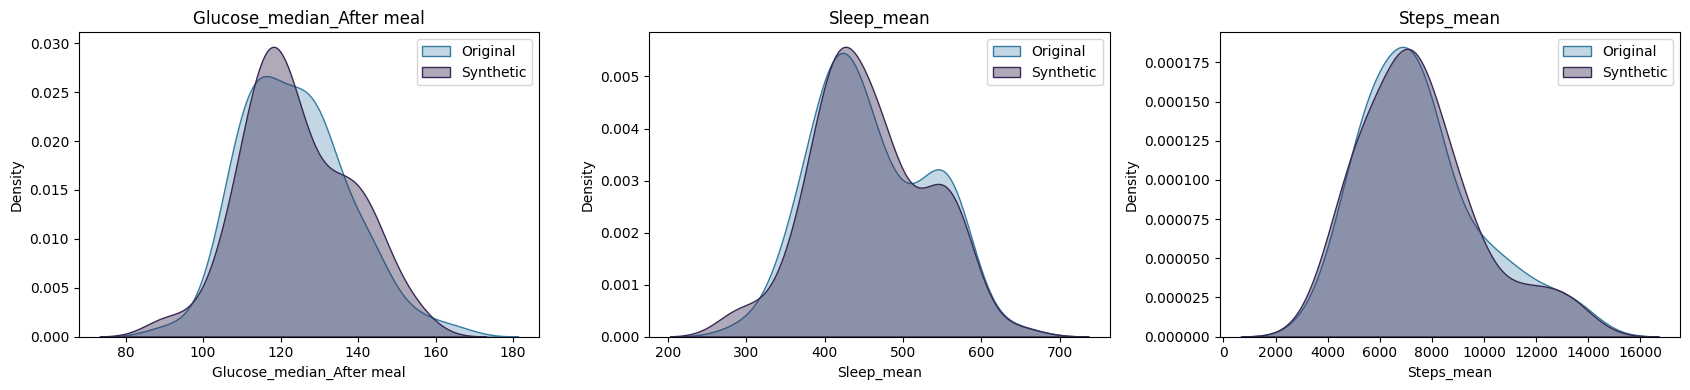

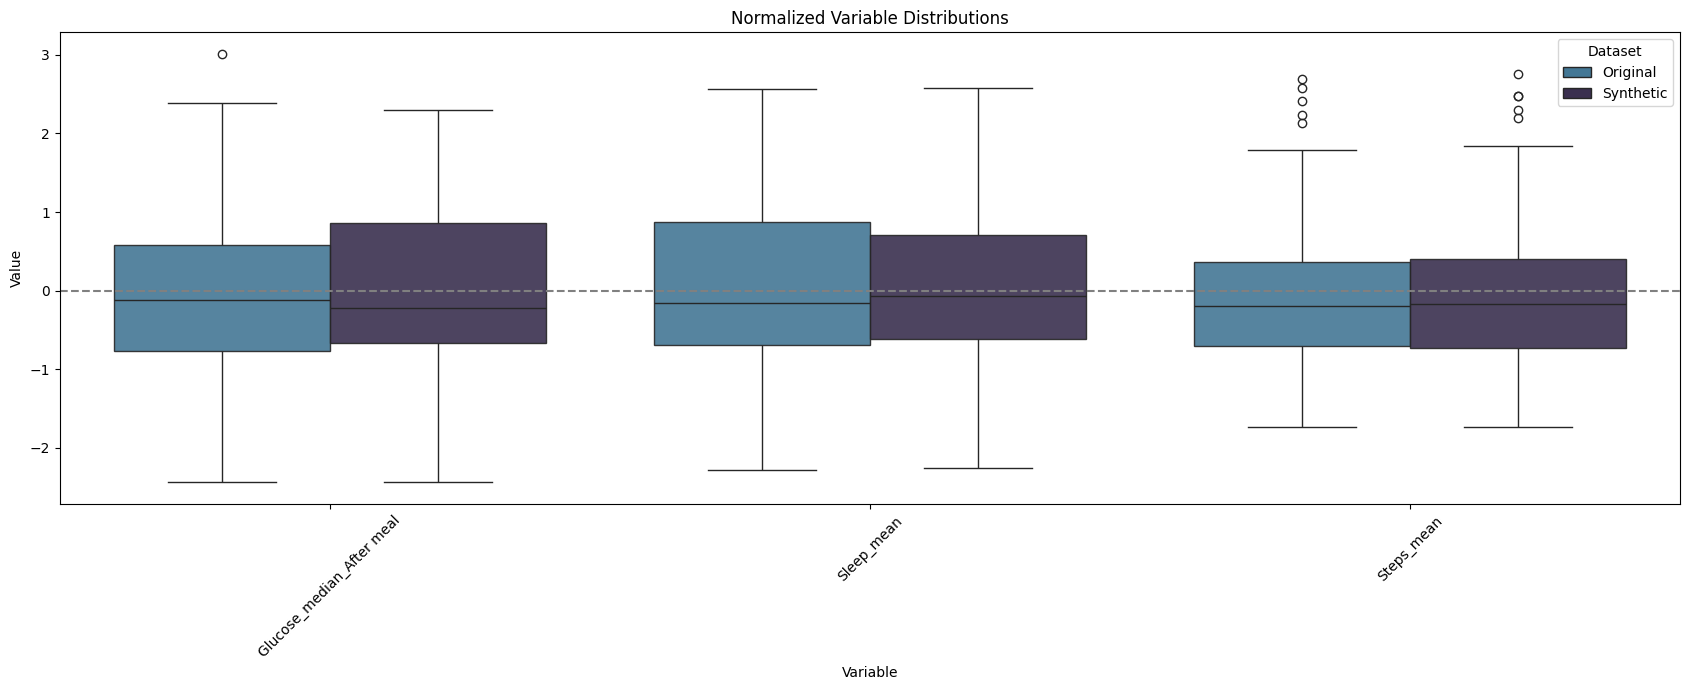


--- Visualizing Patient Trajectories ---


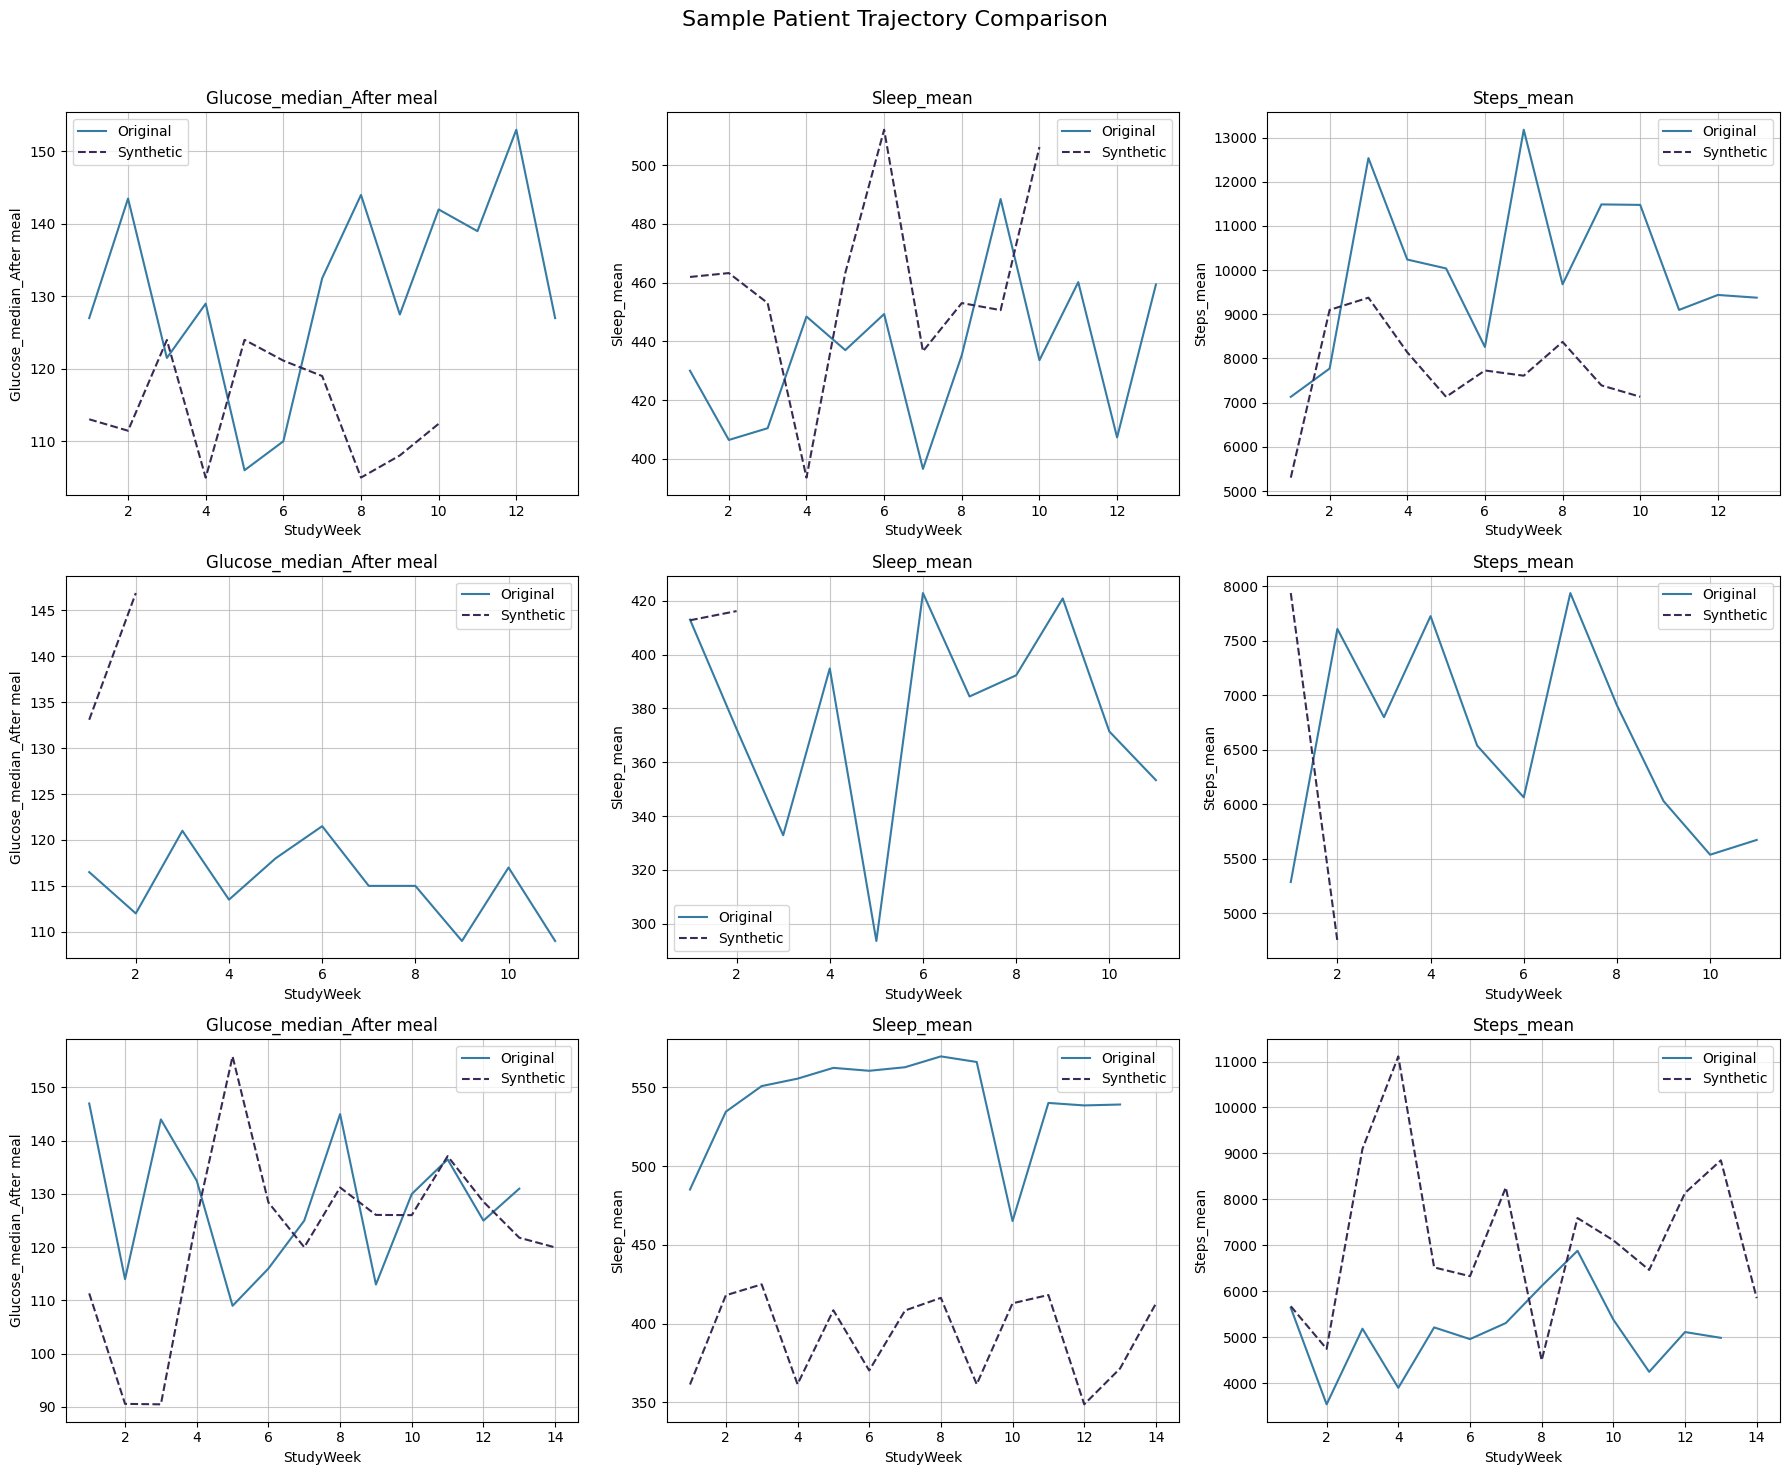

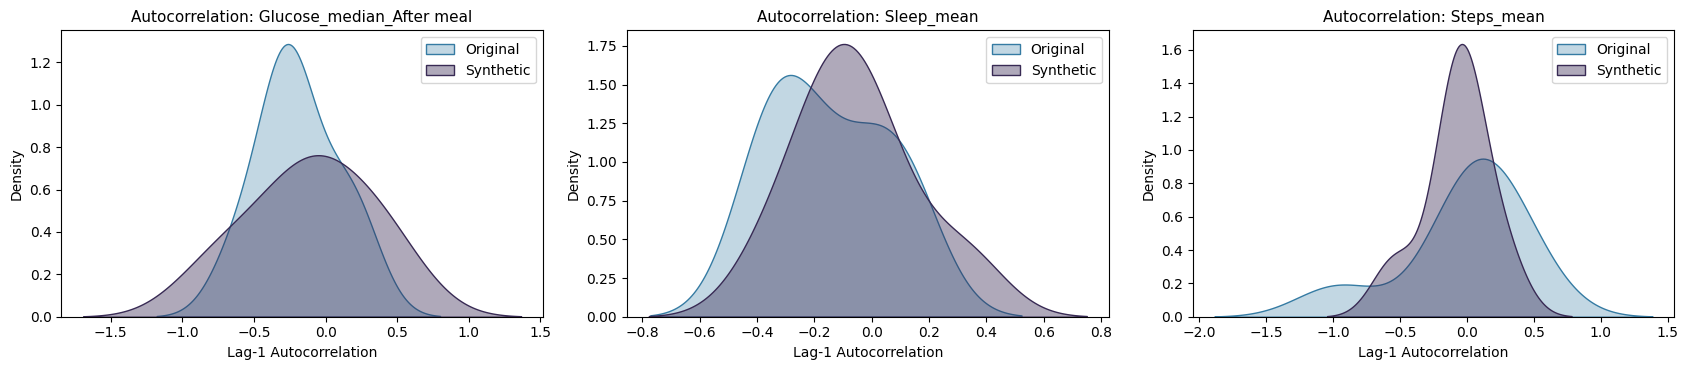

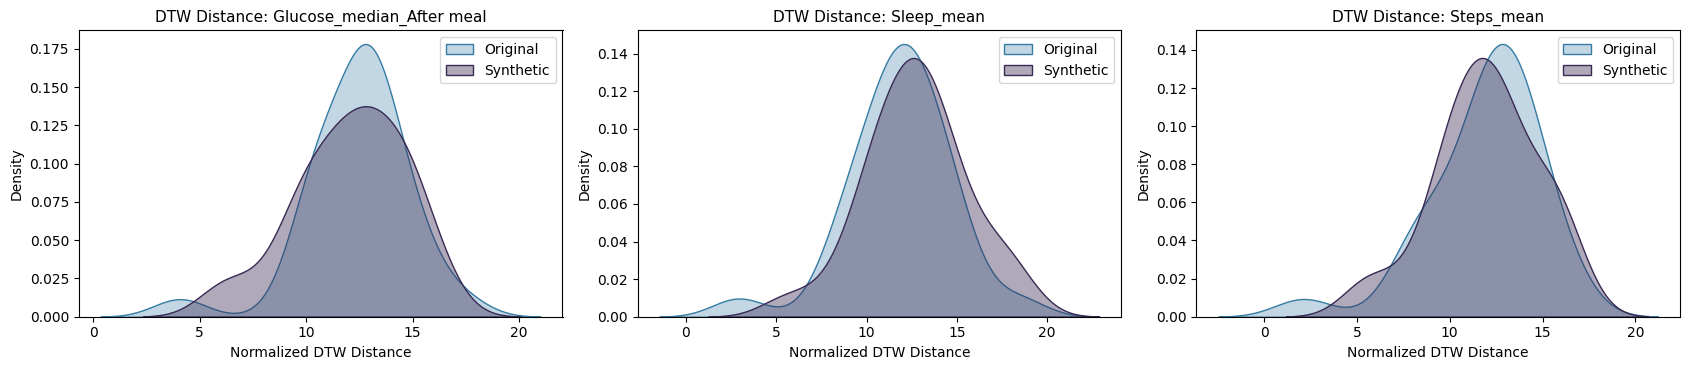


--- Visualizations complete ---


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dtw import dtw
from itertools import combinations
import warnings

warnings.filterwarnings('ignore')
palette = sns.color_palette("mako", 9)
original_color = palette[4]
synthetic_color = palette[1]


# --- Data Preprocessing ---

def preprocess_for_visualization(original_path, synthetic_path, patient_id_col, time_col):
    original_df = pd.read_csv(original_path)
    synthetic_df = pd.read_csv(synthetic_path)

    synthetic_df.columns = original_df.columns
    synthetic_df[time_col] = synthetic_df[time_col].round().astype(int)

    for df in [original_df, synthetic_df]:
        df.sort_values(by=[patient_id_col, time_col], inplace=True)
        first_time_point = df.groupby(patient_id_col)[time_col].transform('first')
        sequential_increment = df.groupby(patient_id_col).cumcount()
        df[time_col] = first_time_point + sequential_increment

    synthetic_df[patient_id_col] = 'SYNTH_' + synthetic_df[patient_id_col].astype(str)
    return original_df, synthetic_df

# --- Visualization Functions ---

def plot_patient_trajectories(original_df, synthetic_df, patient_id_col, time_col, metrics, n_patients=3):
    print("\n--- Visualizing Patient Trajectories ---")
    original_ids = original_df[patient_id_col].unique()
    synthetic_ids = synthetic_df[patient_id_col].unique()
    selected_patient_ids = np.random.choice(original_ids, min(n_patients, len(original_ids)), replace=False)

    fig, axes = plt.subplots(len(selected_patient_ids), len(metrics),
                             figsize=(6 * len(metrics), 5 * len(selected_patient_ids)),
                             squeeze=False)
    fig.suptitle('Sample Patient Trajectory Comparison', fontsize=16)

    for i, patient_id in enumerate(selected_patient_ids):
        orig_patient_data = original_df[original_df[patient_id_col] == patient_id]
        synth_patient_id = np.random.choice(synthetic_ids)
        synth_patient_data = synthetic_df[synthetic_df[patient_id_col] == synth_patient_id]

        for j, metric in enumerate(metrics):
            ax = axes[i, j]
            ax.plot(orig_patient_data[time_col], orig_patient_data[metric], color=original_color, label='Original')
            ax.plot(synth_patient_data[time_col], synth_patient_data[metric], color=synthetic_color, linestyle='--', label='Synthetic')
            ax.set_title(f'{metric}')
            ax.set_xlabel(time_col)
            ax.set_ylabel(metric)
            ax.legend()
            ax.grid(True, alpha=0.7)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_longitudinal_distributions_horizontal(original_df, synthetic_df, patient_id_col, metrics):
    n_metrics = len(metrics)
    cols = 3
    rows = (n_metrics + cols - 1) // cols  # ceiling division

    # --- Autocorrelation KDE Grid ---
    fig1, axes1 = plt.subplots(rows, cols, figsize=(17, 4 * rows), squeeze=False)
    #fig1.suptitle("Autocorrelation Distributions (KDE)", fontsize=18)

    for idx, metric in enumerate(metrics):
        row, col = divmod(idx, cols)

        def get_autocorrelations(df):
            return [
                group[metric].autocorr(lag=1)
                for _, group in df.groupby(patient_id_col)
                if len(group) > 1 and not np.isnan(group[metric].autocorr(lag=1))
            ]

        orig_autocorrs = get_autocorrelations(original_df)
        synth_autocorrs = get_autocorrelations(synthetic_df)

        ax = axes1[row][col]
        sns.kdeplot(orig_autocorrs, label='Original', fill=True, ax=ax,
                    color=original_color, alpha=0.3)
        sns.kdeplot(synth_autocorrs, label='Synthetic', fill=True, ax=ax,
                    color=synthetic_color, alpha=0.4)
        ax.set_title(f"Autocorrelation: {metric}", fontsize=11)
        ax.set_xlabel("Lag-1 Autocorrelation")
        ax.set_ylabel("Density")
        ax.legend()

    # Hide any unused subplots
    for idx in range(n_metrics, rows * cols):
        fig1.delaxes(axes1[idx // cols][idx % cols])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # --- DTW KDE Grid ---
    fig2, axes2 = plt.subplots(rows, cols, figsize=(17, 4 * rows), squeeze=False)
    #fig2.suptitle("DTW Distance Distributions (KDE)", fontsize=18)

    for idx, metric in enumerate(metrics):
        row, col = divmod(idx, cols)

        def get_dtw_distances(df, n_samples=80):
            ids = df[patient_id_col].unique()
            sample_ids = np.random.choice(ids, min(n_samples, len(ids)), replace=False)
            distances = []
            for i, j in combinations(sample_ids, 2):
                series1 = df[df[patient_id_col] == i][metric].dropna().to_numpy()
                series2 = df[df[patient_id_col] == j][metric].dropna().to_numpy()
                if len(series1) > 1 and len(series2) > 1:
                    s1_norm = (series1 - np.mean(series1)) / (np.std(series1) + 1e-9)
                    s2_norm = (series2 - np.mean(series2)) / (np.std(series2) + 1e-9)
                    distance = dtw(s1_norm, s2_norm).distance
                    distances.append(distance)
            return distances

        real_dtw = get_dtw_distances(original_df)
        synth_dtw = get_dtw_distances(synthetic_df)

        ax = axes2[row][col]
        sns.kdeplot(real_dtw, label='Original', fill=True, ax=ax,
                    color=original_color, alpha=0.3)
        sns.kdeplot(synth_dtw, label='Synthetic', fill=True, ax=ax,
                    color=synthetic_color, alpha=0.4)
        ax.set_title(f"DTW Distance: {metric}", fontsize=11)
        ax.set_xlabel("Normalized DTW Distance")
        ax.set_ylabel("Density")
        ax.legend()

    # Hide any unused subplots
    for idx in range(n_metrics, rows * cols):
        fig2.delaxes(axes2[idx // cols][idx % cols])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()






def plot_cross_sectional_visuals(original_df, synthetic_df, metrics):
    print("\n--- Cross-Sectional Comparisons ---")
    numerical_cols = metrics

    # Density Plots
    num_plots = len(numerical_cols)
    rows = (num_plots + 2) // 3
    plt.figure(figsize=(17, rows * 4))
    for i, col in enumerate(numerical_cols):
        plt.subplot(rows, 3, i + 1)
        sns.kdeplot(original_df[col], fill=True, color=original_color, label='Original', alpha=0.3)
        sns.kdeplot(synthetic_df[col], fill=True, color=synthetic_color, label='Synthetic', alpha=0.4)
        plt.title(col)
        plt.legend()
    plt.tight_layout()
    plt.show()

    # Normalized Box Plots
    orig_norm = (original_df[numerical_cols] - original_df[numerical_cols].mean()) / original_df[numerical_cols].std()
    synth_norm = (synthetic_df[numerical_cols] - synthetic_df[numerical_cols].mean()) / synthetic_df[numerical_cols].std()
    orig_norm["Dataset"] = "Original"
    synth_norm["Dataset"] = "Synthetic"

    combined = pd.concat([
        orig_norm.melt(id_vars="Dataset", var_name="Variable", value_name="Value"),
        synth_norm.melt(id_vars="Dataset", var_name="Variable", value_name="Value")
    ])

    plt.figure(figsize=(17, 7))
    ax = sns.boxplot(data=combined, x="Variable", y="Value", hue="Dataset",
                 palette=[original_color, synthetic_color])

    # Set alpha for boxes manually
    for patch in ax.patches:
        patch.set_alpha(0.9)


    plt.axhline(0, color='gray', linestyle='--')
    plt.xticks(rotation=45)
    plt.title("Normalized Variable Distributions")
    plt.tight_layout()
    plt.show()

# ==================== Main Execution ====================

if __name__ == "__main__":
    ORIGINAL_FILE = "/content/drive/MyDrive/THESIS/synthetic-data/diabetes.csv"
    SYNTHETIC_FILE = "/content/drive/MyDrive/THESIS/synthetic-data/synthetic_diabetes_1.csv"
    PATIENT_ID_COLUMN = 'ShortId'
    TIME_COLUMN = 'StudyWeek'

    all_metrics = [
        'Glucose_median_After meal',
        'Sleep_mean',
        'Steps_mean',
        'Glucose_max_Before meal',
        'Hyperglycemia',
        'Glucose_min_After meal'
    ]

    # === Choose which metrics to visualize ===
    # === Choose which metrics to visualize for both plots and distributions ===
    print("\nAvailable metrics for visualization:")
    for idx, metric in enumerate(all_metrics, 1):
        print(f"{idx}. {metric}")
    selected = input("Enter metric numbers separated by commas (e.g., 1,3): ")
    selected_indices = [int(i.strip()) - 1 for i in selected.split(",") if i.strip().isdigit()]
    selected_metrics = [all_metrics[i] for i in selected_indices if i < len(all_metrics)]

    print(f"\nYou selected: {selected_metrics}")


    original_df, synthetic_df = preprocess_for_visualization(
        original_path=ORIGINAL_FILE,
        synthetic_path=SYNTHETIC_FILE,
        patient_id_col=PATIENT_ID_COLUMN,
        time_col=TIME_COLUMN
    )

    # Run plots
    plot_cross_sectional_visuals(original_df, synthetic_df, selected_metrics)
    # Trajectory plots
    plot_patient_trajectories(original_df, synthetic_df, PATIENT_ID_COLUMN, TIME_COLUMN, selected_metrics)

    # DTW and autocorrelation distributions
    plot_longitudinal_distributions_horizontal(original_df, synthetic_df, PATIENT_ID_COLUMN, selected_metrics)

    print("\n--- Visualizations complete ---")
